## Example work-flow:
```simnet_al_clean.py``` is the main simulation file \
use ```runsims_al_clean.py``` to set up a series of simulations (external)

example use cases, and example figures from the paper are included below

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import importlib
import scipy.stats

import params_clean as pm
import methods_clean as me
import simnet_asymm_clean as srin #partial network with RL only, for including fb/ff asymmetries
import simnet_al_clean as snal #full network with AL+RL

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#any modification to defaults will require re-running
def set_defaults(pm): return {item: getattr(pm, item) for item in dir(pm) if not item.startswith("__")}

In [ ]:
defaults = set_defaults(pm)

In [ ]:
def reset_defaults(*args):
    #call this to reset param values to those in the module
    #pass in param module & default var to reset in args as (module, default_var)
    if args:
        pm_t = args[0]
        d = args[1]
        for item in d:
            setattr(pm_t, item, d[item])
        return
    else:
        #default to resetting pm
        for item in defaults:
            setattr(pm, item, defaults[item])
    return

In [ ]:
# Simulate four trials of reduced model with asymmetries
reset_defaults()
pm.ntrials = 4

re_t, ri_t, xe_t, Wlearn, Wdict, perf, ttl = srin.sim(True)

In [ ]:
# Simulate four trials of full AL model
reset_defaults()
pm.ntrials = 4
pm.extstim = 'V-const'

re_t, ri_t, xe_t, Wlearn, Wdict, perf, ttl = snal.sim(True)

## Plot behavioral learning traces

In [24]:
def get_ps(clen, perf0, resp0, stim0):

    a = len(perf0) - clen + 1
    p11 = []
    p21 = []
    resp = np.where(np.array(resp0)==1, 1, 0) #exchange 2's for 0's in response list
    stim = stim0.flatten() #stimulus order

    x1 = np.argwhere(stim == 1)
    x2 = np.argwhere(stim == 2)

    for j in np.arange(a):
        i = np.intersect1d(np.where(x1 > j)[0], np.where(x1 < clen+j)[0])
        p11.append(np.sum(resp[x1[i]])/len(i))

        i = np.intersect1d(np.where(x2 > j)[0], np.where(x2 < clen+j)[0])
        p21.append(np.sum(resp[x2[i]])/len(i))

    acc = np.convolve(np.where(np.array(perf0)==1, 1, 0), np.ones(clen), 'valid')/clen
    
    return p11, p21, acc

In [ ]:
# load datasets
# uncomment specific f[ile]name to load a dataset
dirname = 'example_data/'

##Full models
##dset1 - congruent transfer
fname = 'full_cong*'
#~
##dset2 - incongruent transfer
#fname = 'full_incong*'

##RL Lesion model
##dset1 - congruent transfer
#fname = 'rl-lesion_cong*'

flist = glob.glob(dirname+fname)

p11 = {} #Prob z1|s1, trial 1
p21 = {} #Prob z1|s2, trial 1
p12 = {} #Prob z1|s1, trial 2
p22 = {} #Prob z1|s2, trial 2
acc1 = {}
acc2 = {}

clen = 15

for file in enumerate(flist):
    print(file)
    d = np.load(file[1])

    perf0 = d['perf0']
    resp0 = d['resp0'] #network responses
    stim0 = d['stim0'] #presented stimuli
    
    p1, p2, acc = get_ps(clen, perf0, resp0, stim0)
    p11[file[0]] = p1
    p21[file[0]] = p2
    acc1[file[0]] = acc

    perf1 = d['perf1']
    resp1 = d['resp1']
    stim1 = d['stim1']
    
    p1, p2, acc = get_ps(clen, perf1, resp1, stim1)
    p12[file[0]] = p1
    p22[file[0]] = p2
    acc2[file[0]] = acc

In [30]:
# stack results into matrix
# clip first runs from end backwards to fit shortest trial
# clip second runs from beginning forwards to fit shortest trial

lb1 = len(p11[0])
lb2 = len(p22[0])
#check for shortest series - if ntrials equal for all runs these will be the same
for i in np.arange(1, len(p11)):
    if len(p11[i]) < lb1:
        lb1 = len(p11[i])
    
    if len(p22[i]) < lb2:
        lb2 = len(p22[i])
    
p11m = np.array(p11[0][-lb1:])
p21m = np.array(p21[0][-lb1:])
acc1m = np.array(acc1[0][-lb1:])

p12m = np.array(p12[0][-lb2:])
p22m = np.array(p22[0][-lb2:])
acc2m = np.array(acc2[0][-lb2:])

for i in np.arange(1,len(p11)):
    p11m = np.vstack((p11m, np.array(p11[i][-lb1:])))
    p21m = np.vstack((p21m, np.array(p21[i][-lb1:])))
    acc1m = np.vstack((acc1m, np.array(acc1[i][-lb1:])))
    
    p12m = np.vstack((p12m, np.array(p12[i][:lb2])))
    p22m = np.vstack((p22m, np.array(p22[i][:lb2])))
    acc2m = np.vstack((acc2m, np.array(acc2[i][:lb2])))

In [31]:
# compute summary statistics
p11m0 = np.mean(p11m, axis=0) #compute mean
p21m0 = np.mean(p21m, axis=0)
acc1m0 = np.mean(acc1m, axis=0)

p11s0 = sp.stats.tstd(p11m, axis=0) #compute std
p21s0 = sp.stats.tstd(p21m, axis=0)
acc1s0 = sp.stats.tstd(acc1m, axis=0)

p12m0 = np.mean(p12m, axis=0) #compute mean
p22m0 = np.mean(p22m, axis=0)
acc2m0 = np.mean(acc2m, axis=0)

p12s0 = sp.stats.tstd(p12m, axis=0) #compute std
p22s0 = sp.stats.tstd(p22m, axis=0)
acc2s0 = sp.stats.tstd(acc2m, axis=0)

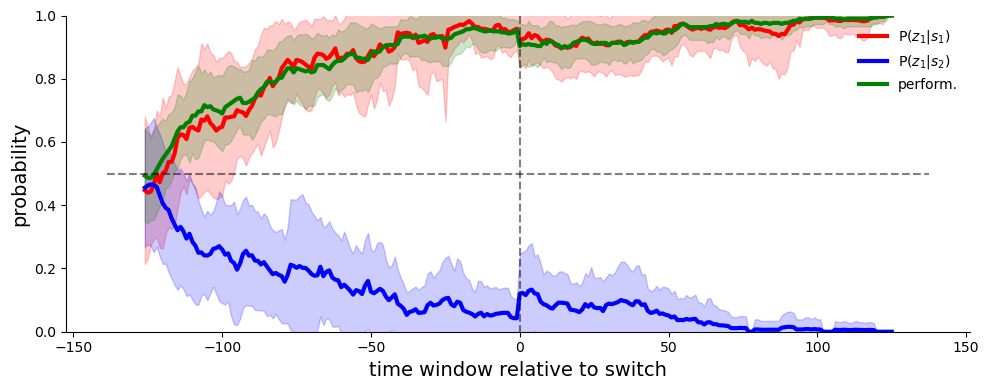

In [32]:
p_up = np.hstack((p11m0, p12m0))
p_dwn = np.hstack((p21m0, p22m0))
c = np.hstack((acc1m0, acc2m0))

p_upv = np.hstack((p11s0, p12s0))
p_dwnv = np.hstack((p21s0, p22s0))
cv = np.hstack((acc1s0, acc2s0))

x = np.hstack((np.arange(-len(p11m0),0), np.arange(len(p12m0))))

plt.figure(figsize=(10,4))

plt.plot(x, p_up, label=r'P($z_1$|$s_1$)', color='r', linewidth=3)
plt.fill_between(x, p_up-p_upv, p_up+p_upv, alpha=0.2, color='r')
plt.plot(x, p_dwn, label=r'P($z_1$|$s_2$)', color='b', linewidth=3)
plt.fill_between(x, p_dwn-p_dwnv, p_dwn+p_dwnv, alpha=0.2, color='b')
plt.plot(x, c, label='perform.', color='g', linewidth=3)
plt.fill_between(x, c-cv, c+cv, alpha=0.2, color='g')

xmn, xmx = plt.gca().get_xlim()
plt.hlines(0.5, xmn, xmx, 'k', 'dashed', alpha=0.5)
ymn, ymx = plt.gca().get_ylim()
plt.vlines(0, ymn, ymx, 'k', 'dashed', alpha=0.5)
plt.ylim([0, 1])
plt.legend(frameon=False)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.ylabel('probability', fontsize=14)
plt.xlabel('time window relative to switch', fontsize=14)
plt.tight_layout()

plt.show()

## Plot readout weights as a function of position in a subnetwork

In [6]:
## load example weights dataset
d = np.load('/home/ge27buw/NAS/labmembers/mattgetz/transfer-learn/example_data/example_weight_data.npz')
#output weights during initial learning: first column, initial random weights
# second column: final output weights
Wlearn0 = d['Wlearn0']
#output weights at end of post-switch relearning phase
Wlearn1 = d['Wlearn1']

In [7]:
# set nice colors
c1 = '#D7A184' #dk brown
c2 = '#D4C2AD' #light brown
c3 = '#025259' #dk teal
c4 = '#248F89' #light teal

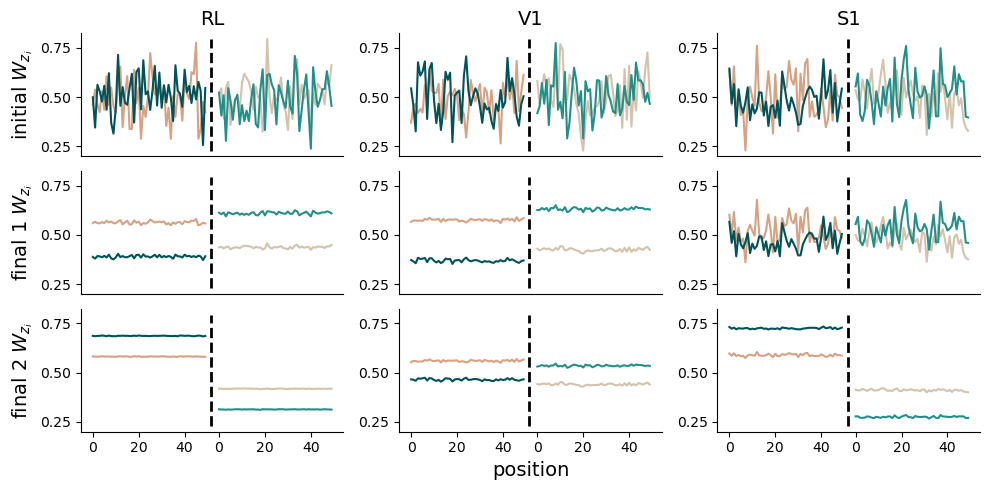

In [9]:
plt.figure(figsize=(10,5))
x1 = np.arange(pm.dim)
o = 5
x2 = np.arange(pm.dim, 2*pm.dim)+o

ax1 = plt.subplot(331)
plt.plot(x1, Wlearn0[:pm.dim,0], color=c1)
plt.plot(x2, Wlearn0[pm.dim:2*pm.dim,0], color=c2)
plt.plot(x1, Wlearn0[6*pm.dim:7*pm.dim,0], color=c3)
plt.plot(x2, Wlearn0[7*pm.dim:8*pm.dim,0], color=c4)
plt.vlines(pm.dim+(o/2)-1, np.min(Wlearn0[:,0]), np.max(Wlearn0[:,0]), 'k', linewidth=2, linestyle='dashed')
plt.ylabel(r'initial $W_{z_i}$', fontsize=14)
ax1.spines[['right', 'top']].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.locator_params(axis='y', nbins=3)
plt.title('RL', fontsize=14)

ax2 = plt.subplot(332, sharey=ax1)
plt.plot(x1, Wlearn0[2*pm.dim:3*pm.dim,0], color=c1)
plt.plot(x2, Wlearn0[3*pm.dim:4*pm.dim,0], color=c2)
plt.plot(x1, Wlearn0[8*pm.dim:9*pm.dim,0], color=c3)
plt.plot(x2, Wlearn0[9*pm.dim:10*pm.dim,0], color=c4)
plt.vlines(pm.dim+(o/2)-1, np.min(Wlearn0[:,0]), np.max(Wlearn0[:,0]), 'k', linewidth=2, linestyle='dashed')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.spines[['right', 'top']].set_visible(False)
plt.title('V1', fontsize=14)

ax3 = plt.subplot(333, sharey=ax1)
plt.plot(x1, Wlearn0[4*pm.dim:5*pm.dim,0], color=c1)
plt.plot(x2, Wlearn0[5*pm.dim:6*pm.dim,0], color=c2)
plt.plot(x1, Wlearn0[10*pm.dim:11*pm.dim,0], color=c3)
plt.plot(x2, Wlearn0[11*pm.dim:12*pm.dim,0], color=c4)
plt.vlines(pm.dim+(o/2)-1, np.min(Wlearn0[:,0]), np.max(Wlearn0[:,0]), 'k', linewidth=2, linestyle='dashed')
ax3.spines[['right', 'top']].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('S1', fontsize=14)

ax4 = plt.subplot(334)
plt.plot(x1, Wlearn0[:pm.dim,-1], color=c1)
plt.plot(x2, Wlearn0[pm.dim:2*pm.dim,-1], color=c2)
plt.plot(x1, Wlearn0[6*pm.dim:7*pm.dim,-1], color=c3)
plt.plot(x2, Wlearn0[7*pm.dim:8*pm.dim,-1], color=c4)
plt.vlines(pm.dim+(o/2)-1, np.min(Wlearn0[:,0]), np.max(Wlearn0[:,0]), 'k', linewidth=2, linestyle='dashed')
ax4.spines[['right', 'top']].set_visible(False)
plt.ylabel(r'final 1 $W_{z_i}$', fontsize=14)
plt.locator_params(axis='y', nbins=3)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax5 = plt.subplot(335, sharey=ax4)
plt.plot(x1, Wlearn0[2*pm.dim:3*pm.dim,-1], color=c1)
plt.plot(x2, Wlearn0[3*pm.dim:4*pm.dim,-1], color=c2)
plt.plot(x1, Wlearn0[8*pm.dim:9*pm.dim,-1], color=c3)
plt.plot(x2, Wlearn0[9*pm.dim:10*pm.dim,-1], color=c4)
plt.vlines(pm.dim+(o/2)-1, np.min(Wlearn0[:,0]), np.max(Wlearn0[:,0]), 'k', linewidth=2, linestyle='dashed')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.spines[['right', 'top']].set_visible(False)

ax6 = plt.subplot(336, sharey=ax4)
plt.plot(x1, Wlearn0[4*pm.dim:5*pm.dim,-1], color=c1)
plt.plot(x2, Wlearn0[5*pm.dim:6*pm.dim,-1], color=c2)
plt.plot(x1, Wlearn0[10*pm.dim:11*pm.dim,-1], color=c3)
plt.plot(x2, Wlearn0[11*pm.dim:12*pm.dim,-1], color=c4)
plt.vlines(pm.dim+(o/2)-1, np.min(Wlearn0[:,0]), np.max(Wlearn0[:,0]), 'k', linewidth=2, linestyle='dashed')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.spines[['right', 'top']].set_visible(False)

ax7 = plt.subplot(337)
plt.plot(x1, Wlearn1[:pm.dim], color=c1)
plt.plot(x2, Wlearn1[pm.dim:2*pm.dim], color=c2)
plt.plot(x1, Wlearn1[6*pm.dim:7*pm.dim], color=c3)
plt.plot(x2, Wlearn1[7*pm.dim:8*pm.dim], color=c4)
plt.vlines(pm.dim+(o/2)-1, np.min(Wlearn0[:,0]), np.max(Wlearn0[:,0]), 'k', linewidth=2, linestyle='dashed')
plt.xticks([0, 20, 40, 55, 75, 95], [0, 20, 40, 0, 20, 40])
ax7.spines[['right', 'top']].set_visible(False)
plt.ylabel(r'final 2 $W_{z_i}$', fontsize=14)
plt.locator_params(axis='y', nbins=3)

ax8 = plt.subplot(338, sharey=ax7)
plt.plot(x1, Wlearn1[2*pm.dim:3*pm.dim], color=c1)
plt.plot(x2, Wlearn1[3*pm.dim:4*pm.dim], color=c2)
plt.plot(x1, Wlearn1[8*pm.dim:9*pm.dim], color=c3)
plt.plot(x2, Wlearn1[9*pm.dim:10*pm.dim], color=c4)
plt.vlines(pm.dim+(o/2)-1, np.min(Wlearn0[:,0]), np.max(Wlearn0[:,0]), 'k', linewidth=2, linestyle='dashed')
plt.xticks([0, 20, 40, 55, 75, 95], [0, 20, 40, 0, 20, 40])
ax8.spines[['right', 'top']].set_visible(False)
plt.xlabel('position', fontsize=14)

ax9 = plt.subplot(339, sharey=ax7)
plt.plot(x1, Wlearn1[4*pm.dim:5*pm.dim], color=c1)
plt.plot(x2, Wlearn1[5*pm.dim:6*pm.dim], color=c2)
plt.plot(x1, Wlearn1[10*pm.dim:11*pm.dim], color=c3)
plt.plot(x2, Wlearn1[11*pm.dim:12*pm.dim], color=c4)
plt.vlines(pm.dim+(o/2)-1, np.min(Wlearn0[:,0]), np.max(Wlearn0[:,0]), 'k', linewidth=2, linestyle='dashed')
plt.xticks([0, 20, 40, 55, 75, 95], [0, 20, 40, 0, 20, 40])
ax9.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()